 **This notebook estimates skin, average pressure and productivity index from pressure build-ups**

In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from google.colab import files
from google.colab import drive
drive.mount('/content/gdrive/')

import sys
sys.path.append('gdrive/My Drive/Colab Notebooks')
import pdg_monitoring
from pdg_monitoring import *

#-------------------------------------------------------------------#
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE, titleweight='bold')     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE, labelweight='bold')    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
#-------------------------------------------------------------------#


Mounted at /content/gdrive/


In [2]:
well='X'
filename='X_P.csv'
tt,qq,pp,BSW=read_file(filename)

Saving X_P.csv to X_P.csv


In [19]:
# ROCK AND FLUID PROPS
rw=0.156
h=198.4
por=0.127
Bo=1.03005
visc=0.653595
ct=1.57503e-4
p_ref=534.40

# BUILD-UP PROPS
date_ref=['18/12/2016']

t_ini=[1814.659,5858.472,11458.75,14358.46,24019.10]
date=['18/12/2016','05/06/2017','24/01/2018','25/05/2018','02/07/2019']
q=[4525.00,4303.00,4100.00,4000.00,3857.00]
shut=[10.0,10.0,10.0,10.0,10.0]
tr=[0.3,0.3,0.3,0.3,0.3]
smooth=[0.1,0.1,0.1,0.1,0.1]

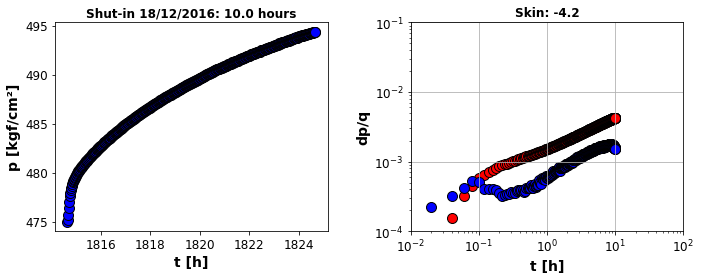

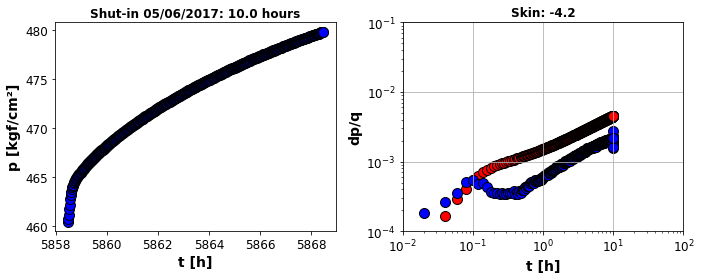

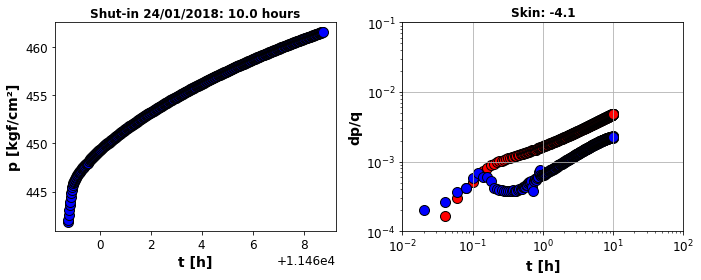

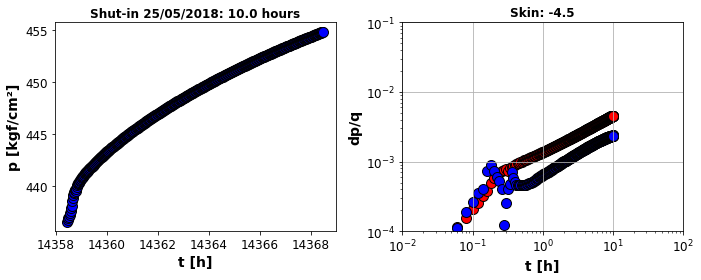

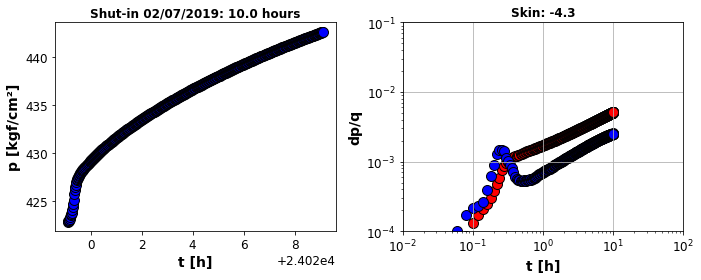

In [27]:
# CREATE LISTS
skin=[]
rate=[]
bhp=[]
IP=[]
t_ana=[]
water=[]

# LOOP THROUGH BUILD-UPS
i=0
n_shuts=len(shut)

while i<n_shuts:
  rate.append(q[i]) #append new rate
  pwf=np.interp(t_ini[i],tt,pp) #read BHP
  bhp.append(pwf) #append BHP
  t_ana.append(t_ini[i]) #append new t0 
  w=np.interp(t_ini[i],tt,BSW) #read BSW
  water.append(w) #append new BSW

  t,p=ReturnBuildUp(t_ini[i],shut[i],tt,pp) #clip out build-up
  dt=t-t[0] #elapsed time
  dp=p-p[0] #delta_pws
  der=calc_derivative(dt,dp,smooth[i]) #derivative
  der=der/q[i] #normalize derivative
  dp=dp/q[i] #normalize dp
  dp_radial=np.interp(tr[i],dt,dp) #read dp from IARF
  der_radial=np.interp(tr[i],dt,der) #read dp' from IARF
  
  if i==0: #calculations for reference build-up
    k=0.5*19.03*Bo*visc/(h*der_radial) 
    dp_radial_ref=1.151*2*der_radial*(np.log10(tr[i])+np.log10((0.0003484*k)/(por*visc*ct*rw*rw))+0.3514)
    der_radial_ref=der_radial
    q_ref=q[i]
    dpq_radial_ref=dp_radial
    dp_skin=dp_radial-dp_radial_ref
    s=0.5*dp_skin/der_radial_ref
    pi=q[i]/(p_ref-pwf)
    IP_ref=pi
    df_t= pd.DataFrame(dt, columns=date_ref)
    df_dp= pd.DataFrame(dp, columns=date_ref)
    df_der= pd.DataFrame(der, columns=date_ref)
    plot_analysis(t,p,dt,dp,der,s,shut[i],date[i],1e-2,1e2,1e-4,1e-1)
    i=i+1
  else: #math for any other build-up
    dp_skin=dp_radial-dp_radial_ref
    s=0.5*dp_skin/der_radial_ref
    pi=1/((1/IP_ref)+dp_radial-dpq_radial_ref)
    df_t[date[i]]=pd.DataFrame(dt)
    df_dp[date[i]]= pd.DataFrame(dp)
    df_der[date[i]]= pd.DataFrame(der)
    plot_analysis(t,p,dt,dp,der,s,shut[i],date[i],1e-2,1e2,1e-4,1e-1)
    i=i+1
  skin.append(s)
  IP.append(pi)  
  
p_avg=np.array(bhp)+np.array(rate)/np.array(IP)  

# Diagnostic Plots

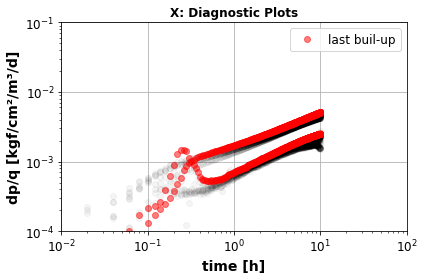

In [28]:
ShowAllLogLog(df_t,df_dp,df_der,1e-2,1e2,1e-4,1e-1,well)

# Monitoring: average pressure, BHP and Q

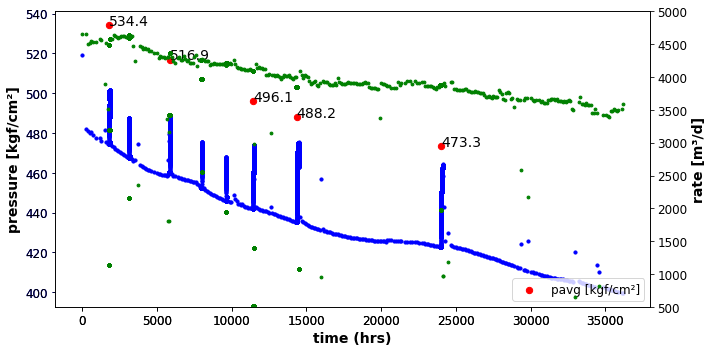

In [29]:
PlotBHPandRateandPavg(tt,pp,qq,p_avg,t_ana,500,5000)

# Monitoring: skin

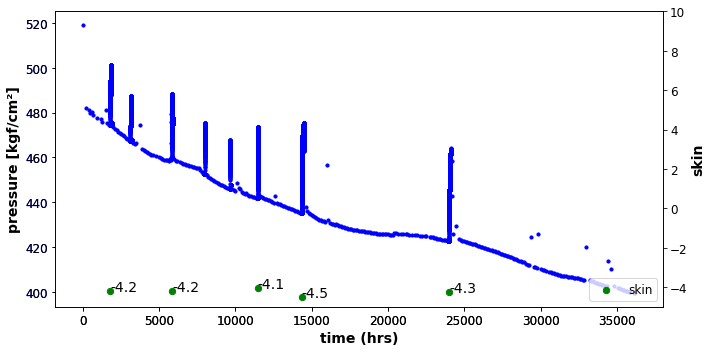

In [30]:
PlotBHPandRateandSkin(tt,pp,skin,t_ana,-5,10)

# Monitoring: IP

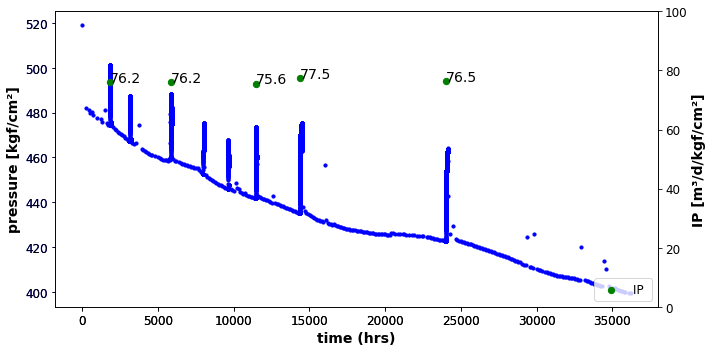

In [31]:
PlotBHPandRateandIP(tt,pp,IP,t_ana,0,100)

# Cross plots: skin vs BSW & skin vs IP

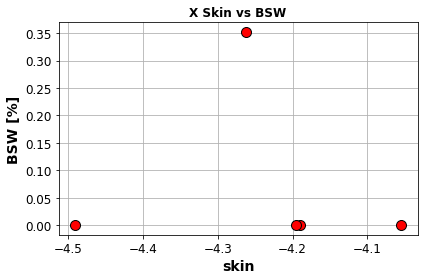

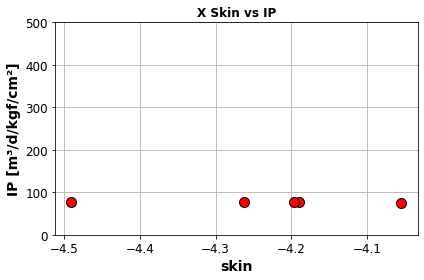

In [32]:
SkinBSW(skin,water,well)
SkinIP(skin,IP,well,0,500)

In [33]:
#%%shell
#jupyter nbconvert /content/pdg_spy.ipynb --to=html --TemplateExporter.exclude_input=True